# A Primer on Bayesian Methods for Multilevel Modeling

Hierarchical or multilevel modeling is a generalization of regression modeling.

*Multilevel models* are regression models in which the constituent model parameters are given **probability models**. This implies that model parameters are allowed to **vary by group**.

Observational units are often naturally **clustered**. Clustering induces dependence between observations, despite random sampling of clusters and random sampling within clusters.

A *hierarchical model* is a particular multilevel model where parameters are nested within one another.

Some multilevel structures are not hierarchical. 

* e.g. "country" and "year" are not nested, but may represent separate, but overlapping, clusters of parameters

We will motivate this topic using an environmental epidemiology example.

### Example: Radon contamination (Gelman and Hill 2006)

Let's revisit the radon contamination example from the previous section. For hierarchical modeling, we will use more of the data; we will focus on modeling radon levels in Minnesota. The EPA did the radon study  in 80,000 houses. There were two important predictors:

* measurement in basement or first floor (radon higher in basements)
* county uranium level (positive correlation with radon levels)

The hierarchy in this example is households within county. 

### Data organization

First, we import the data from a local file -- these data are only for the State of Minnesota.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import xarray as xr

In [2]:
# Import radon data
radon_data = pd.read_csv('../data/radon.csv', index_col=0)
RANDOM_SEED = 20090425

np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
counties = radon_data.county.unique()
n_counties = counties.shape[0]
county = radon_data.county_code.values
log_radon = radon_data.log_radon.values
floor = radon_data.floor.astype(int).values
log_uranium = np.log(radon_data.Uppm.values)
county_lookup = dict(zip(counties, np.arange(n_counties)))

Distribution of radon levels in MN (log scale):

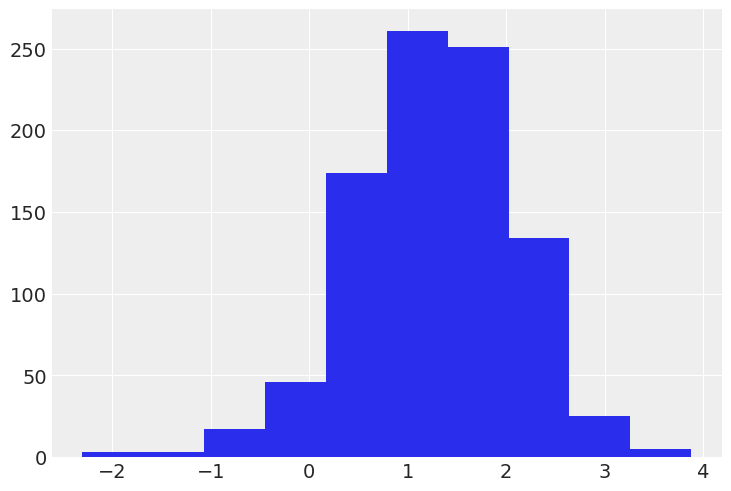

In [4]:
radon_data.log_radon.hist();

## Conventional approaches

The two conventional alternatives to modeling radon exposure represent the two extremes of the bias-variance tradeoff:

***Complete pooling***: 

Treat all counties the same, and estimate a single radon level.

$$y_i = \alpha + \beta x_i + \epsilon_i$$

***No pooling***:

Model radon in each county independently.

$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

where $j = 1,\ldots,85$

The errors $\epsilon_i$ may represent measurement error, temporal within-house variation, or variation among houses.

We’ll start by estimating the slope and intercept for the complete pooling model:

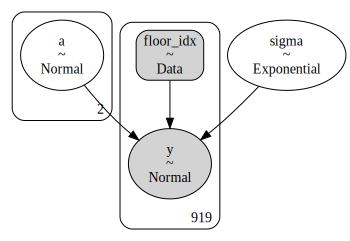

In [5]:
coords = {"Level": ["Basement", "Floor"], "obs_id": np.arange(floor.size)}

with pm.Model(coords=coords) as pooled_model:
    a = pm.Normal("a", 0.0, sigma=10.0, dims="Level")
    sigma = pm.Exponential("sigma", 1.0)

    floor_idx = pm.Data("floor_idx", floor, dims="obs_id")
    y = pm.Normal("y", mu=a[floor_idx], sigma=sigma, observed=log_radon, dims="obs_id")

pm.model_to_graphviz(pooled_model)

Before sampling, it is useful to conduct **prior predictive checks** to ensure that our priors are appropriate, and do not unduly constrain inference.

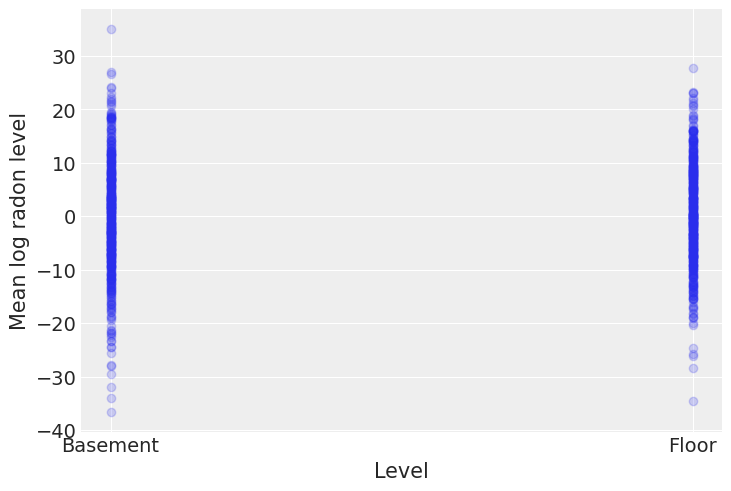

In [6]:
with pooled_model:    
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    idata_prior = az.from_pymc3(prior=prior_checks)

_, ax = plt.subplots()
idata_prior.prior.plot.scatter(x="Level", y="a", alpha=0.2, ax=ax)
ax.set_ylabel("Mean log radon level");

These look fine -- they allow for any radon values that we would reasonably expect to see in the data.

In [7]:
with pooled_model:
    pooled_trace = pm.sample(return_inferencedata=False, random_seed=RANDOM_SEED)
    az.summary(pooled_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


0, dim: obs_id, 919 =? 919
0, dim: obs_id, 919 =? 919


Let’s see what it means on the outcome space: did the model pick-up the negative relationship between floor measurements and log radon levels? What’s the uncertainty around its estimates? To estimate the uncertainty around the household radon levels (not the _average_ level, but measurements that would be likely in _individual_ households), we need to sample the likelihood $y$ from the model. In another words, we need to do posterior predictive checks:

In [8]:
with pooled_model:
    ppc = pm.sample_posterior_predictive(pooled_trace, random_seed=RANDOM_SEED)
    pooled_idata = az.from_pymc3(pooled_trace, posterior_predictive=ppc, prior=prior_checks)

0, dim: obs_id, 919 =? 919


---
### Bonus

We now want to calculate the highest density interval given by the posterior predictive on radon levels. However, we are not interested in the HDI of each _observation_ but in the HDI of each _level_. We can groupby xarray objects: in this particular case, each `groupby` wil have the same 3 dimensions as the original input (`chain, draw, obs_id`). What will change is the length of the `obs_id` dimension: in the first group it will be the number of basement level observations, and in the second the number of floor level observations.

In [9]:
hdi_helper = lambda ds: az.hdi(ds, input_core_dims=[["chain", "draw", "obs_id"]])
hdi_ppc = (
    pooled_idata.posterior_predictive.y.groupby(pooled_idata.constant_data.floor_idx)
    .apply(hdi_helper)
    .y
)
hdi_ppc

<xarray.DataArray 'y' (floor_idx: 2, hdi: 2)>
array([[-0.13161962,  2.84866316],
       [-0.70958819,  2.26813248]])
Coordinates:
  * hdi        (hdi) <U6 'lower' 'higher'
  * floor_idx  (floor_idx) int64 0 1

We will now add one extra coordinate to the `observed_data` group: the `Level` labels (not indices). This will allow xarray to automatically generate the correct `xlabel` and `xticklabels` so we don’t have to worry about labeling too much:

In [10]:
level_labels = pooled_idata.posterior.Level[pooled_idata.constant_data.floor_idx]
pooled_idata.observed_data = pooled_idata.observed_data.assign_coords(Level=level_labels).sortby(
    "Level"
)

---

Let's look at our posterior inferences:

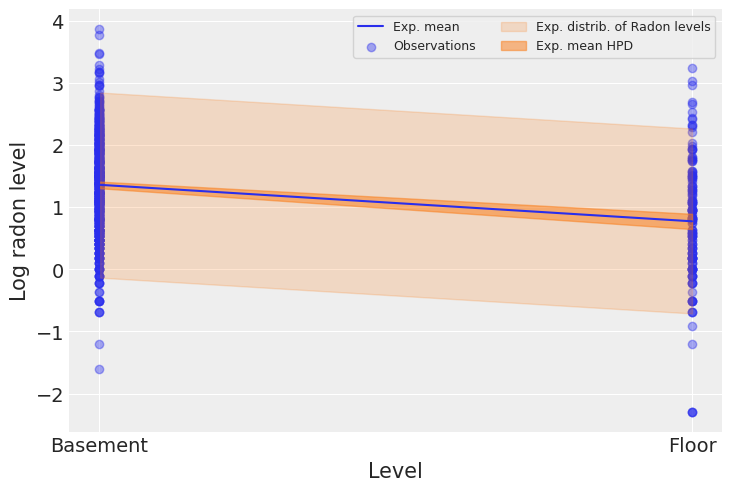

In [11]:
pooled_means = pooled_idata.posterior.mean(dim=("chain", "draw"))

_, ax = plt.subplots()
pooled_idata.observed_data.plot.scatter(x="Level", y="y", label="Observations", alpha=0.4, ax=ax)

az.plot_hdi(
    [0, 1],
    hdi_data=hdi_ppc,
    fill_kwargs={"alpha": 0.2, "label": "Exp. distrib. of Radon levels"},
    ax=ax,
)

az.plot_hdi(
    [0, 1], pooled_idata.posterior.a, fill_kwargs={"alpha": 0.5, "label": "Exp. mean HPD"}, ax=ax
)
ax.plot([0, 1], pooled_means.a, label="Exp. mean")

ax.set_ylabel("Log radon level")
ax.legend(ncol=2, fontsize=9, frameon=True);

We can infer that floor level does account for some of the variation in radon levels. We can see however that the model underestimates the dispersion in radon levels across households – lots of them lie outside the light orange prediction envelope. So this model is a good start but we can’t stop there.

Let’s compare it to the unpooled model, where we estimate the radon level for each county:

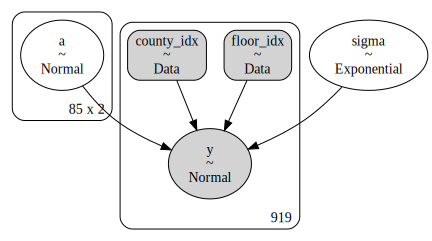

In [12]:
coords["County"] = counties

with pm.Model(coords=coords) as unpooled_model:
    a = pm.Normal("a", 0.0, sigma=10.0, dims=("County", "Level"))

    sigma = pm.Exponential("sigma", 1.0)
    
    floor_idx = pm.Data("floor_idx", floor, dims="obs_id")
    county_idx = pm.Data("county_idx", county, dims="obs_id")

    y = pm.Normal("y", a[county_idx, floor_idx], sigma=sigma, observed=log_radon, dims="obs_id")

pm.model_to_graphviz(unpooled_model)

In [13]:
with unpooled_model:
    unpooled_idata = pm.sample(return_inferencedata=True, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


0, dim: obs_id, 919 =? 919


Let’s look at the expected values for both basement and floor in each county:

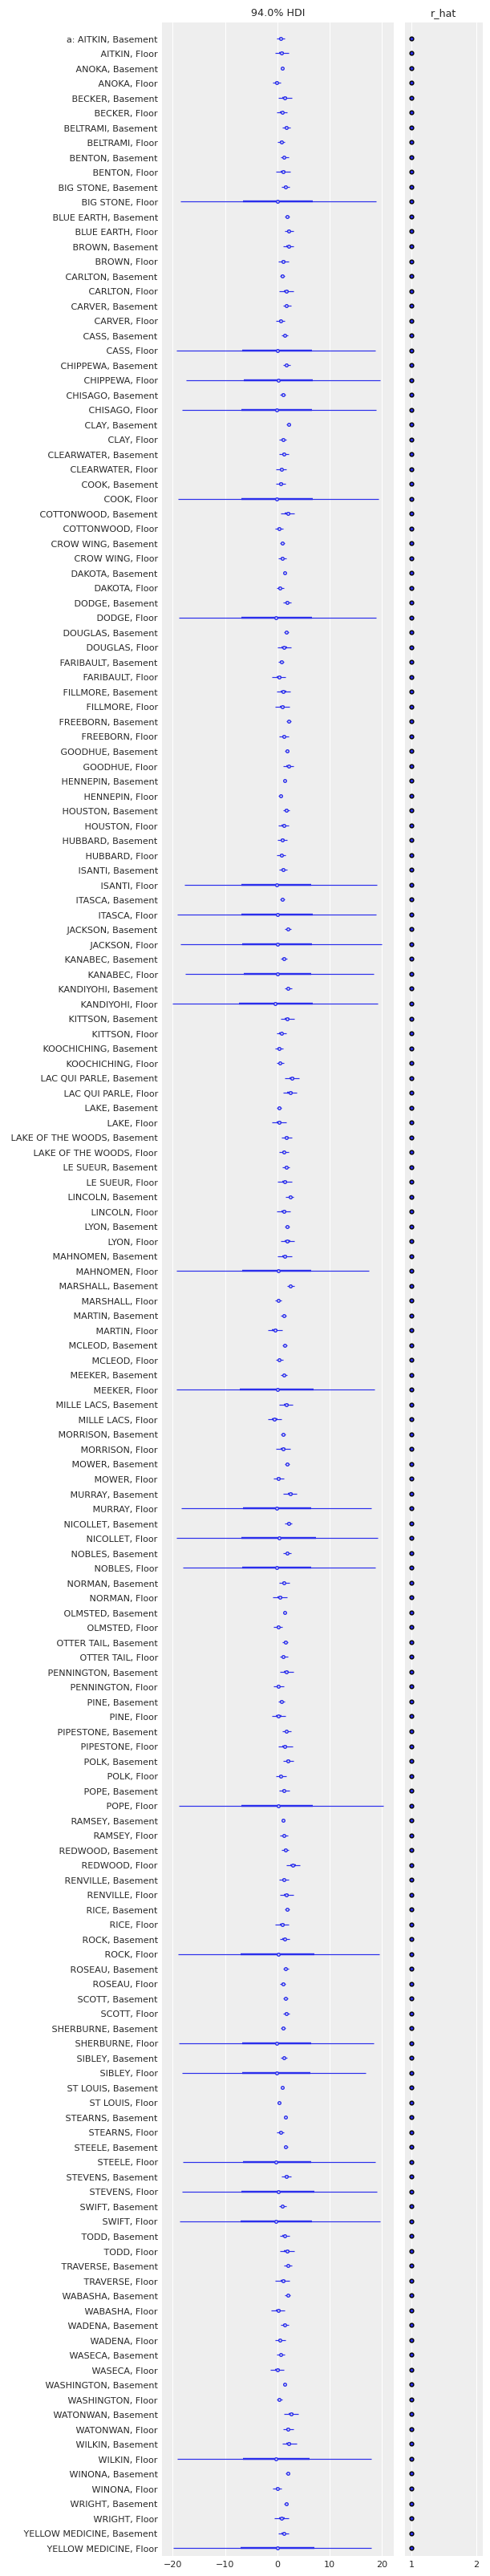

In [14]:
az.plot_forest(
    unpooled_idata, var_names="a", figsize=(6, 32), r_hat=True, combined=True, textsize=8
);

Sampling was good for all counties, but you can see that some are more uncertain than others, and all of these uncertain estimates are for floor measurements. This probably comes from the fact that some counties just have a handful of floor measurements, so the model is pretty uncertain about them.

To identify counties with high radon levels, we can plot the ordered mean estimates, as well as their 94% HDI:

In [15]:
unpooled_means = unpooled_idata.posterior.mean(dim=("chain", "draw"))
unpooled_hdi = az.hdi(unpooled_idata)
unpooled_means

<xarray.Dataset>
Dimensions:  (County: 85, Level: 2)
Coordinates:
  * County   (County) object 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'
  * Level    (Level) <U8 'Basement' 'Floor'
Data variables:
    a        (County, Level) float64 0.6697 0.8332 0.9512 ... 1.227 -0.03798
    sigma    float64 0.7178

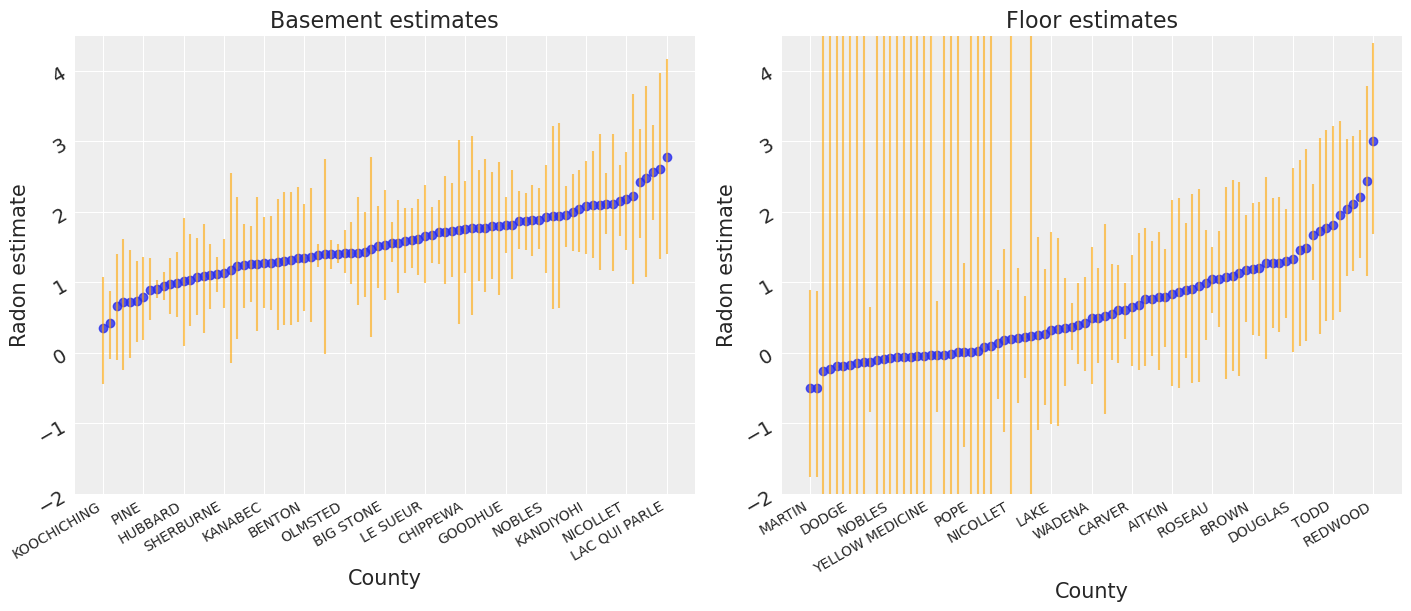

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
xticks = np.arange(0, n_counties + 1, 6)
fontdict = {"horizontalalignment": "right", "fontsize": 10}

for ax, level in zip(axes, ["Basement", "Floor"]):
    unpooled_means_iter = unpooled_means.sel(Level=level).sortby("a")
    unpooled_hdi_iter = unpooled_hdi.sel(Level=level).sortby(unpooled_means_iter.a)
    unpooled_means_iter.plot.scatter(x="County", y="a", ax=ax, alpha=0.8)
    
    ax.vlines(
        np.arange(n_counties),
        unpooled_hdi_iter.a.sel(hdi="lower"),
        unpooled_hdi_iter.a.sel(hdi="higher"),
        color="orange",
        alpha=0.6,
    )
    
    ax.set(title=f"{level.title()} estimates", ylabel="Radon estimate", ylim=(-2, 4.5))
    ax.set_xticks(xticks)
    ax.set_xticklabels(unpooled_means_iter.County.values[xticks], fontdict=fontdict)
    ax.tick_params(rotation=30)

As we saw in the forest plot, floor estimates are globally more uncertain, especially in some counties. We speculated that this is due to smaller sample sizes for these counties, but let’s verify it!

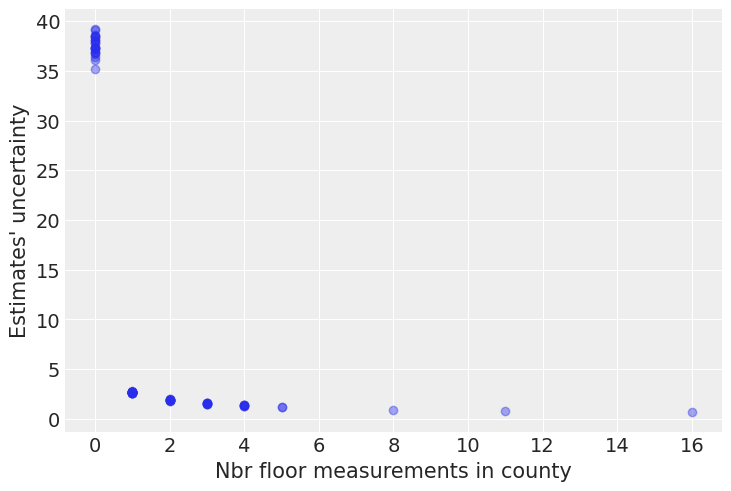

In [17]:
n_floor_meas = radon_data.groupby("county").sum().floor
uncertainty = unpooled_hdi.a.sel(hdi="higher", Level="Floor") - unpooled_hdi.a.sel(
    hdi="lower", Level="Floor"
)

plt.plot(n_floor_meas, uncertainty, "o", alpha=0.4)
plt.xlabel("Nbr floor measurements in county")
plt.ylabel("Estimates' uncertainty");

Bingo! This makes sense: it’s very hard to estimate floor radon levels in counties where there are no floor measurements, and the model is telling us that by being very uncertain in its estimates for those counties. This is a classic issue with no-pooling models: when you estimate clusters independently from each other, what do you do with small-sample-size counties?

Another way to see this phenomenon is to visually compare the pooled and unpooled estimates for a subset of counties representing a range of sample sizes (like we did in the bonus above, we add a couple of extra coordinates to help in data processing and plotting):

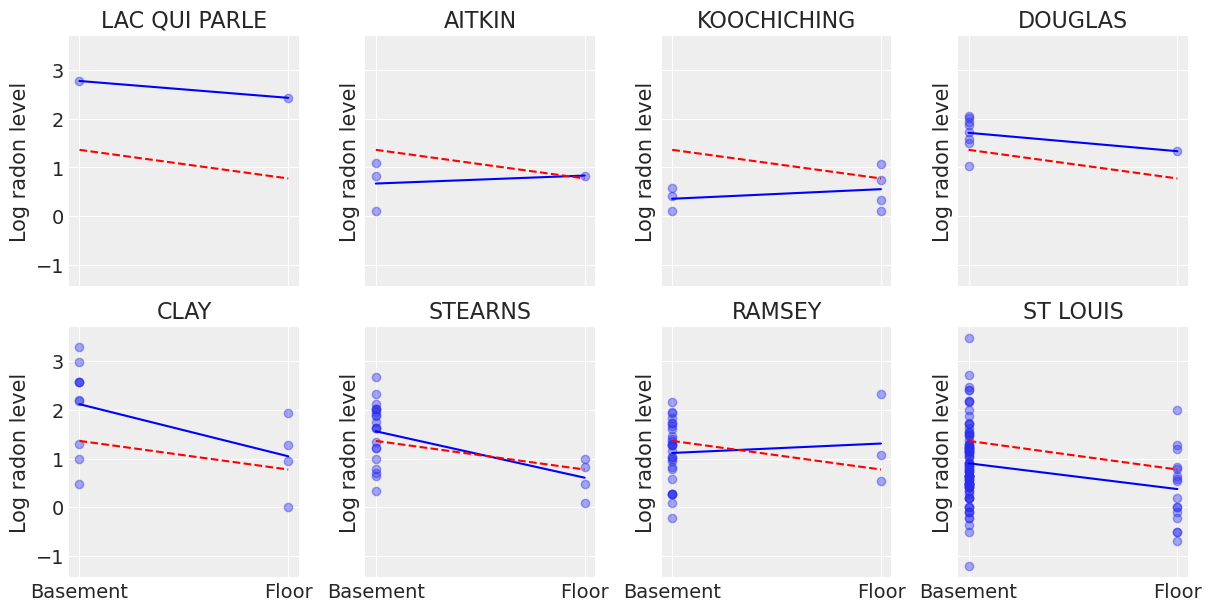

In [18]:
SAMPLE_COUNTIES = (
    "LAC QUI PARLE",
    "AITKIN",
    "KOOCHICHING",
    "DOUGLAS",
    "CLAY",
    "STEARNS",
    "RAMSEY",
    "ST LOUIS",
)

unpooled_idata.observed_data = unpooled_idata.observed_data.assign_coords(
    {
        "County": ("obs_id", counties[unpooled_idata.constant_data.county_idx]),
        "Level": (
            "obs_id",
            unpooled_idata.posterior.Level[unpooled_idata.constant_data.floor_idx],
        ),
    }
)

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
for ax, c in zip(axes.ravel(), SAMPLE_COUNTIES):
    sample_county_mask = unpooled_idata.observed_data.County.isin([c])

    # plot obs:
    unpooled_idata.observed_data.where(sample_county_mask, drop=True).sortby("Level").plot.scatter(
        x="Level", y="y", ax=ax, alpha=0.4
    )

    # plot both models:
    ax.plot([0, 1], unpooled_means.a.sel(County=c), "b")
    ax.plot([0, 1], pooled_means.a, "r--")

    ax.set_title(c)
    ax.set_xlabel("")
    ax.set_ylabel("Log radon level")

Neither of these models are satisfactory:

* If we are trying to identify high-radon counties, pooling is useless – because, by definition, the pooled model estimates radon at the state-level. In other words, pooling leads to maximal underfitting: the variation across counties is not taken into account and only the overall population is estimated.

* We do not trust extreme unpooled estimates produced by models using few observations. This leads to maximal overfitting: only the within-county variations are taken into account and the overall population (i.e the state level, which tells us about similarites across counties) is not estimated.

This issue is acute for small sample sizes, as seen above: in counties where we have few floor measurements, if radon levels are higher in floors than ins basements for those given data points  (e.g Aitkin, Koochiching, Ramsey), the model will estimate that radon levels are higher in floors than basements for these counties. But we shouldn’t trust this conclusion, because both scientific knowledge and the situation in other counties tell us that it is usually the reverse (basement radon > floor radon). 

So, unless we have a lot of observations telling us otherwise for a given county, we should be skeptical and shrink our county-estimates to the state-estimates – in other words, we should balance between individual-level and population-level information, and the amount of shrinkage will depend on how extreme and how numerous the data in each cluster are.

How do we do that, you ask? Well, ladies and gentlemen, let me introduce you to… hierarchical models!

## Multilevel and hierarchical models

When we pool our data, we imply that they are sampled from the same model. This ignores any variation among sampling units (other than sampling variance) -- we assume that counties are all the same::

![pooled](images/pooled_model.png)

When we analyze data unpooled, we imply that they are sampled independently from separate models. At the opposite extreme from the pooled case, this approach claims that differences between sampling units are too large to combine them -- we assume that counties have no similarity whatsoever:

![unpooled](images/unpooled_model.png)

In a hierarchical model, parameters are viewed as a sample from a population distribution of parameters. Thus, we view them as being neither entirely different or exactly the same. This is ***partial pooling***.

![hierarchical](images/partially_pooled_model.png)

We can use PyMC to easily specify multilevel models, and fit them using Markov chain Monte Carlo.

## Partial pooling model

The simplest partial pooling model for the household radon dataset is one which simply estimates radon levels, without any predictors at any level. A partial pooling model represents a compromise between the pooled and unpooled extremes, approximately a weighted average (based on sample size) of the unpooled county estimates and the pooled estimates:

* Estimates for counties with smaller sample sizes will shrink towards the state-wide average.

* Estimates for counties with larger sample sizes will be closer to the unpooled county estimates and will influence the the state-wide average.

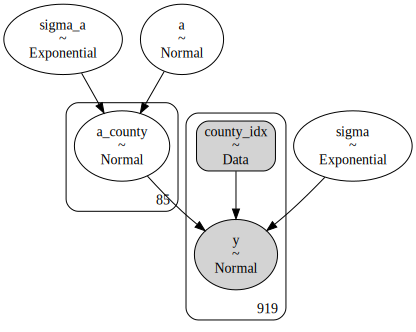

In [19]:
with pm.Model(coords=coords) as partial_pooling:
    
    # Hyperpriors:
    a = pm.Normal("a", mu=0.0, sigma=10.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)

    # Varying intercepts:
    a_county = pm.Normal("a_county", mu=a, sigma=sigma_a, dims="County")

    # Expected value per county:
    county_idx = pm.Data("county_idx", county, dims="obs_id")
    theta = a_county[county_idx]
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

pm.model_to_graphviz(partial_pooling)

In [20]:
with partial_pooling:
    partial_pooling_idata = pm.sample(tune=2000, return_inferencedata=True, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a_county, sigma_a, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


0, dim: obs_id, 919 =? 919


The number of effective samples is smaller than 25% for some parameters.


To compare partial-pooling and no-pooling estimates, let’s run the unpooled model without the `floor` predictor:

In [21]:
with pm.Model(coords=coords) as unpooled_bis:
    a_county = pm.Normal("a_county", 0.0, sigma=10.0, dims="County")

    county_idx = pm.Data("county_idx", county, dims="obs_id")
    theta = a_county[county_idx]
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

    unpooled_idata_bis = pm.sample(tune=2000, return_inferencedata=True, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a_county]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


0, dim: obs_id, 919 =? 919


Now let’s compare both models’ estimates for all 85 counties. We’ll plot the estimates against each county’s sample size, to let you see more clearly what hierarchical models bring to the table:

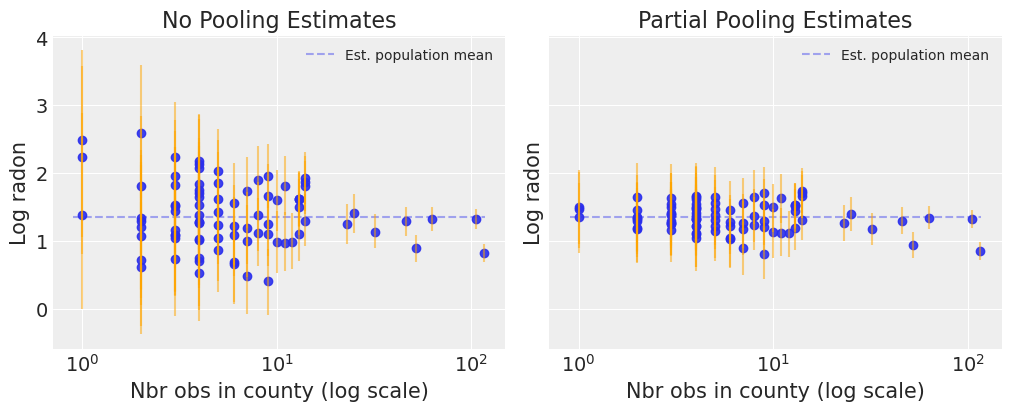

In [22]:
N_county = radon_data.groupby("county")["idnum"].count().values

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for ax, idata, level in zip(
    axes,
    (unpooled_idata_bis, partial_pooling_idata),
    ("no pooling", "partial pooling"),
):

    # add variable with x values to xarray dataset
    idata.posterior = idata.posterior.assign_coords({"N_county": ("County", N_county)})
    # plot means
    idata.posterior.mean(dim=("chain", "draw")).plot.scatter(
        x="N_county", y="a_county", ax=ax, alpha=0.9
    )
    ax.hlines(
        partial_pooling_idata.posterior.a.mean(),
        0.9,
        max(N_county) + 1,
        alpha=0.4,
        ls="--",
        label="Est. population mean",
    )

    # plot hdi
    hdi = az.hdi(idata).a_county
    ax.vlines(N_county, hdi.sel(hdi="lower"), hdi.sel(hdi="higher"), color="orange", alpha=0.5)

    ax.set(
        title=f"{level.title()} Estimates",
        xlabel="Nbr obs in county (log scale)",
        xscale="log",
        ylabel="Log radon",
    )
    ax.legend(fontsize=10)

Notice the difference between the unpooled and partially-pooled estimates, particularly at smaller sample sizes: As expected, the former are both more extreme and more imprecise. Indeed, in the partially-pooled model, estimates in small-sample-size counties are informed by the population parameters – hence more precise estimates. Moreover, the smaller the sample size, the more regression towards the overall mean (the dashed gray line) – hence less extreme estimates. In other words, the model is skeptical of extreme deviations from the population mean in counties where data are sparse.

Now let’s try to integrate the floor predictor! To show you an example with a slope we’re gonna take the indicator variable road, but we could stay with the index variable approach that we used for the no-pooling model. Then we would have one intercept for each category – basement and floor.

## Varying intercepts model

As above, this model allows intercepts to vary across county, according to a random effect. We just add a fixed slope for the predictor (i.e all counties will have the same slope):

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

where

$$\epsilon_i \sim N(0, \sigma_y^2)$$

and the intercept random effect:

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$

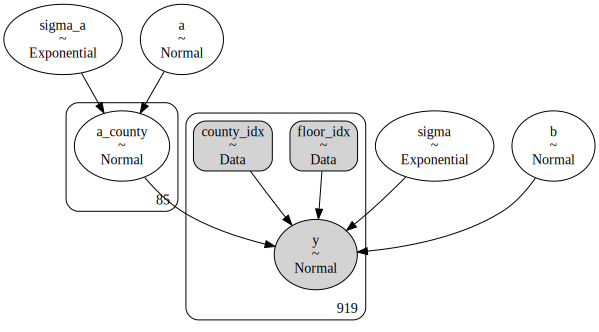

In [23]:
with pm.Model(coords=coords) as varying_intercept:
    
    # Hyperpriors:
    a = pm.Normal("a", mu=0.0, sigma=10.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)

    # Varying intercepts:
    a_county = pm.Normal("a_county", mu=a, sigma=sigma_a, dims="County")
    # Common slope:
    b = pm.Normal("b", mu=0.0, sigma=10.0)

    # Expected value per county:
    floor_idx = pm.Data("floor_idx", floor, dims="obs_id")
    county_idx = pm.Data("county_idx", county, dims="obs_id")
    theta = a_county[county_idx] + b * floor_idx
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

pm.model_to_graphviz(varying_intercept)

In [24]:
with varying_intercept:
    varying_intercept_idata = pm.sample(
        tune=2000, random_seed=RANDOM_SEED, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a_county, sigma_a, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


0, dim: obs_id, 919 =? 919


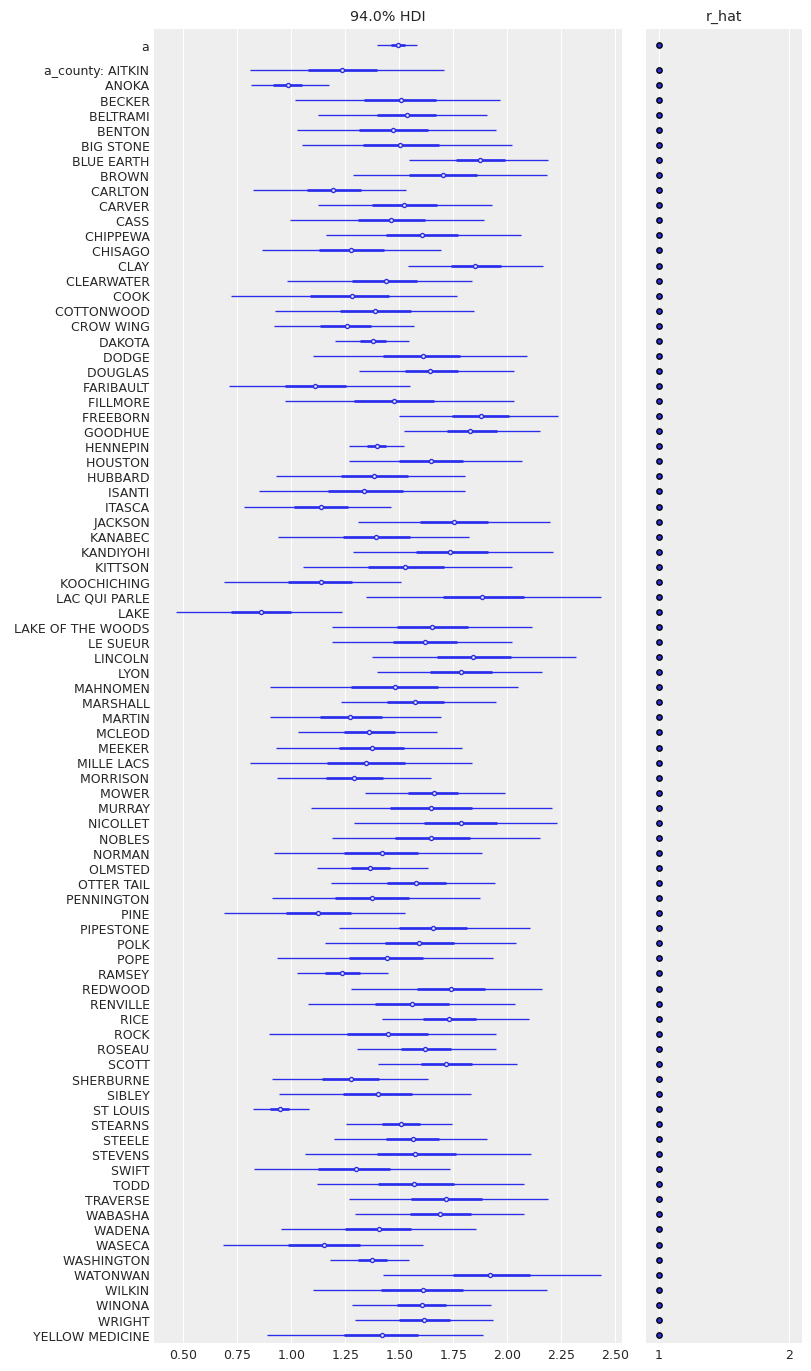

In [25]:
az.plot_forest(
    varying_intercept_idata, var_names=["a", "a_county"], r_hat=True, combined=True, textsize=9
);

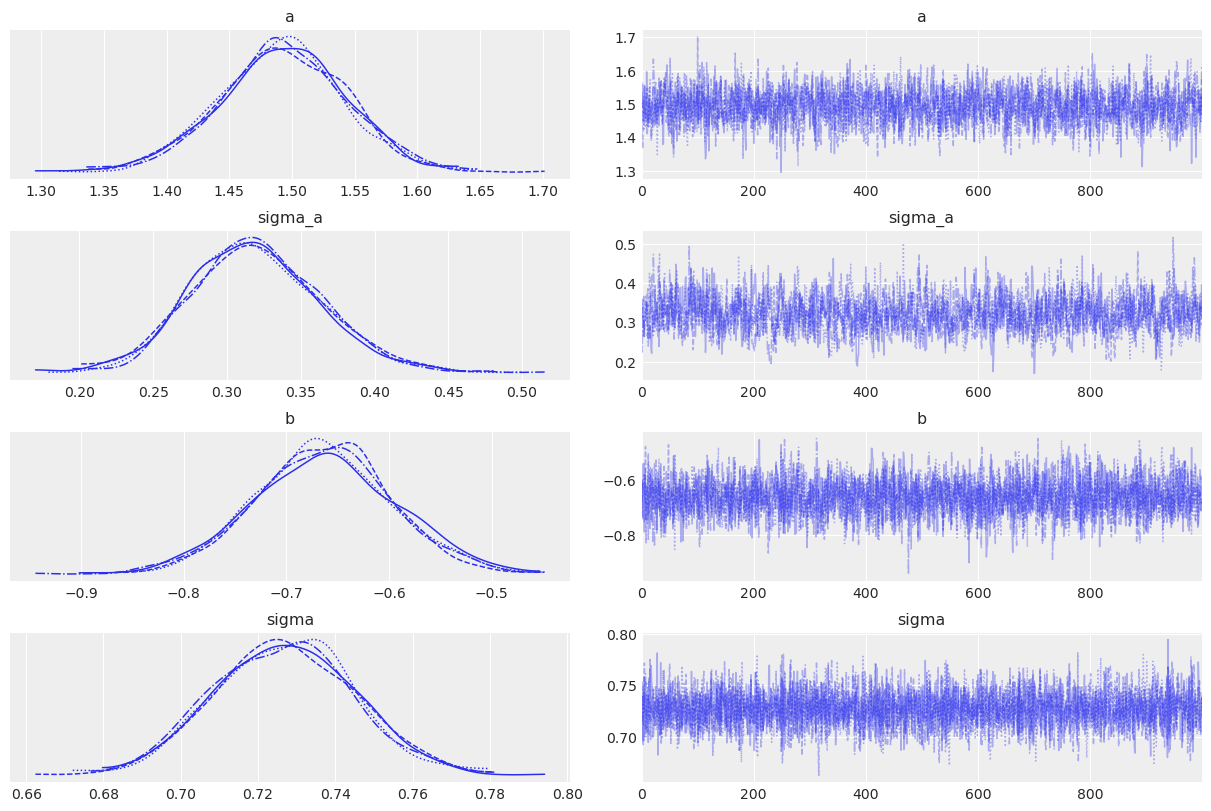

In [26]:
az.plot_trace(varying_intercept_idata, var_names=["a", "sigma_a", "b", "sigma"]);

`b`, the estimate for the `floor` coefficient is approximately -0.66, which can be interpreted as houses without basements having about half ($\exp(-0.66) = 0.52$) the radon levels of those with basements, after accounting for county.

Note that this is only the relative effect of floor on radon levels: conditional on being in a given county, radon is expected to be half lower in houses without basements than in houses with. To see how much difference a basement makes on the absolute level of radon, we’d have to push the parameters through the model, as we do with posterior predictive checks and as we’ll do just now.

_Bonus: To do so, we will take advantage of automatic broadcasting with xarray. We want to create a 2D array with dimensions `(County, Level)`. Our variable `a_county` already has the `County` dimension. `b` however is a scalar. We will multiply `b` with an `xvals` DataArray to introduce the `Level` dimension into the mix. xarray will handle everything from there -- no loops nor reshapings required._

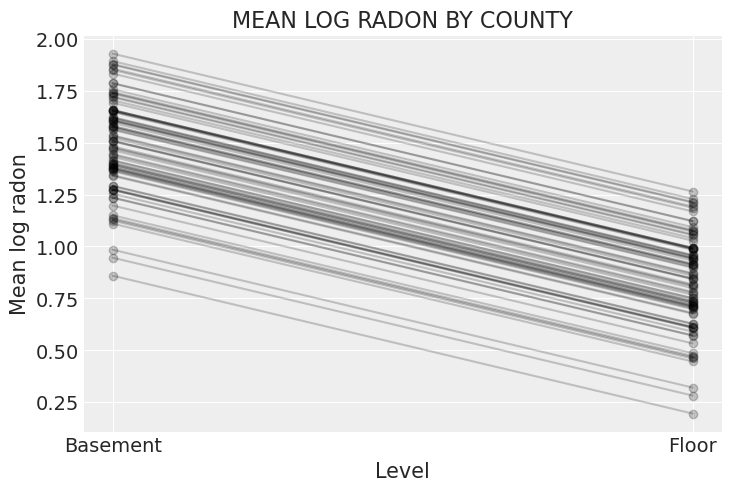

In [27]:
xvals = xr.DataArray([0, 1], dims="Level", coords={"Level": ["Basement", "Floor"]})
post = varying_intercept_idata.posterior  # alias for readability
theta = (
    (post.a_county + post.b * xvals).mean(dim=("chain", "draw")).to_dataset(name="Mean log radon")
)

_, ax = plt.subplots()
theta.plot.scatter(x="Level", y="Mean log radon", alpha=0.2, color="k", ax=ax)
ax.plot(xvals, theta["Mean log radon"].T, "k-", alpha=0.2)
ax.set_title("MEAN LOG RADON BY COUNTY");

The graph above shows, for each county, the expected log radon level and the average effect of having no basement – these are the absolute effects we were talking about. Two caveats though: 

1. This graph doesn’t show the uncertainty for each county – how confident are we that the average estimates are where the graph shows? For that we’d need to combine the uncertainty in `a_county` and `b`, and this would of course vary by county. I didn’t show it here because the graph would get cluttered, but go ahead and do it for a subset of counties. 

2. These are only _average_ estimates at the _county level_ (`theta` in the model): they don’t take into account the variation by _household_. To add this other layer of uncertainty we’d need to take stock of the effect of `sigma` and generate samples from the `y` variable to see the effect on given households (that’s exactly the role of posterior predictive checks).

That being said, it is easy to show that the partial pooling model provides more objectively reasonable estimates than either the pooled or unpooled models, at least for counties with small sample sizes:

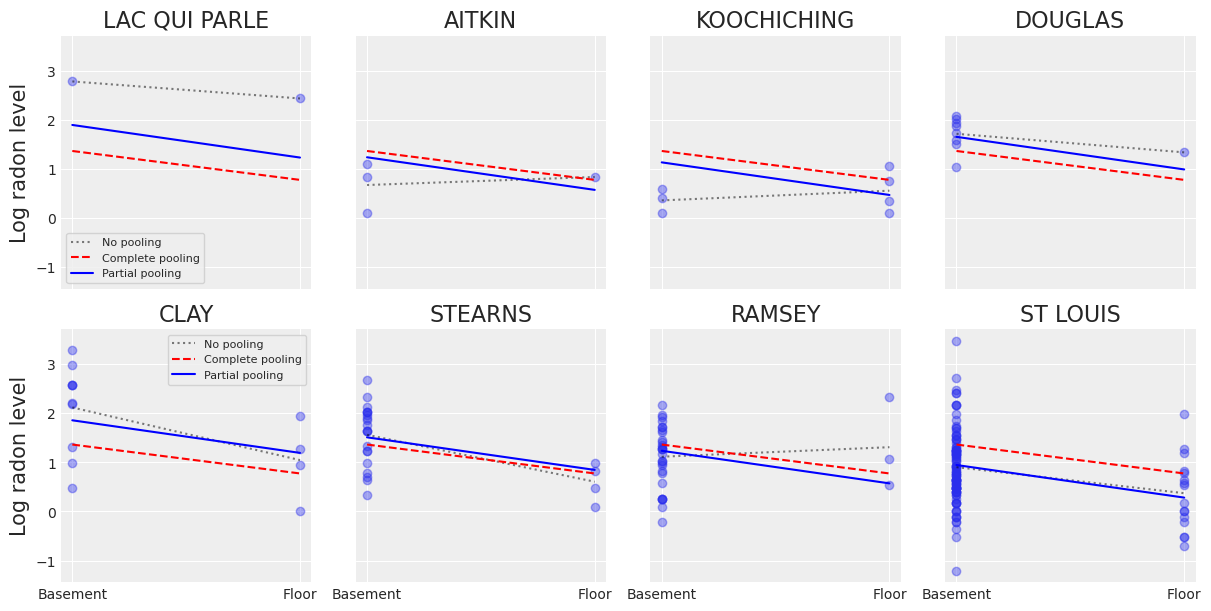

In [28]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
for ax, c in zip(axes.ravel(), SAMPLE_COUNTIES):
    sample_county_mask = unpooled_idata.observed_data.County.isin([c])

    # plot obs:
    unpooled_idata.observed_data.where(sample_county_mask, drop=True).sortby("Level").plot.scatter(
        x="Level", y="y", ax=ax, alpha=0.4
    )

    # plot models:
    ax.plot([0, 1], unpooled_means.a.sel(County=c), "k:", alpha=0.5, label="No pooling")
    ax.plot([0, 1], pooled_means.a, "r--", label="Complete pooling")
    ax.plot([0, 1], theta["Mean log radon"].sel(County=c), "b", label="Partial pooling")

    ax.set_title(c)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(labelsize=10)

axes[0, 0].set_ylabel("Log radon level")
axes[1, 0].set_ylabel("Log radon level")
axes[0, 0].legend(fontsize=8, frameon=True), axes[1, 0].legend(fontsize=8, frameon=True);

Here we clearly see the notion that partial-pooling is a compromise between no pooling and complete pooling, as its mean estimates are usually between the other models’ estimates. And interestingly, the bigger (smaller) the sample size in a given county, the closer the partial-pooling estimates are to the no-pooling (complete-pooling) estimates.

We see however that counties vary by more than just their baseline rates: the effect of floor seems to be different from one county to another. It would be great if our model could take that into account, wouldn’t it? Well to do that, we need to allow the slope to vary by county – not only the intercept.

## Varying slopes model

But before that, let's consider an alternative: we can posit a model that allows the counties to vary according to how the location of measurement (basement or floor) influences the radon reading.

$$y_i = \alpha + \beta_{j[i]} x_{i} + \epsilon_i$$

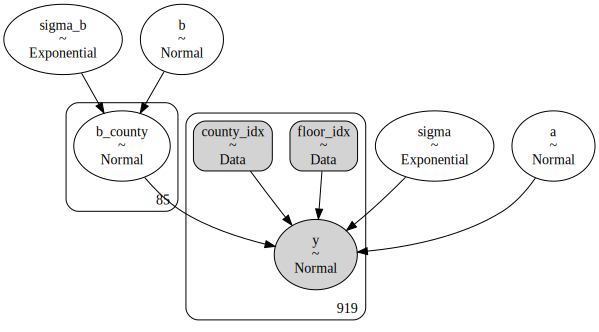

In [31]:
with pm.Model(coords=coords) as varying_slope:
    # Hyperpriors:
    b = pm.Normal("b", mu=0.0, sigma=10.0)
    sigma_b = pm.Exponential("sigma_b", 1.0)

    # Common intercept:
    a = pm.Normal("a", mu=0.0, sigma=10.0)    
    # Varying slopes:
    b_county = pm.Normal("b_county", mu=b, sigma=sigma_b, dims="County")

    # Expected value per county:
    floor_idx = pm.Data("floor_idx", floor, dims="obs_id")
    county_idx = pm.Data("county_idx", county, dims="obs_id")
    theta = a + b_county[county_idx] * floor_idx
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")

pm.model_to_graphviz(varying_slope)

In [32]:
with varying_slope:
    varying_slope_idata = pm.sample(
        tune=2000, random_seed=RANDOM_SEED, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_county, a, sigma_b, b]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 19 seconds.


0, dim: obs_id, 919 =? 919


There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6943205485372341, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


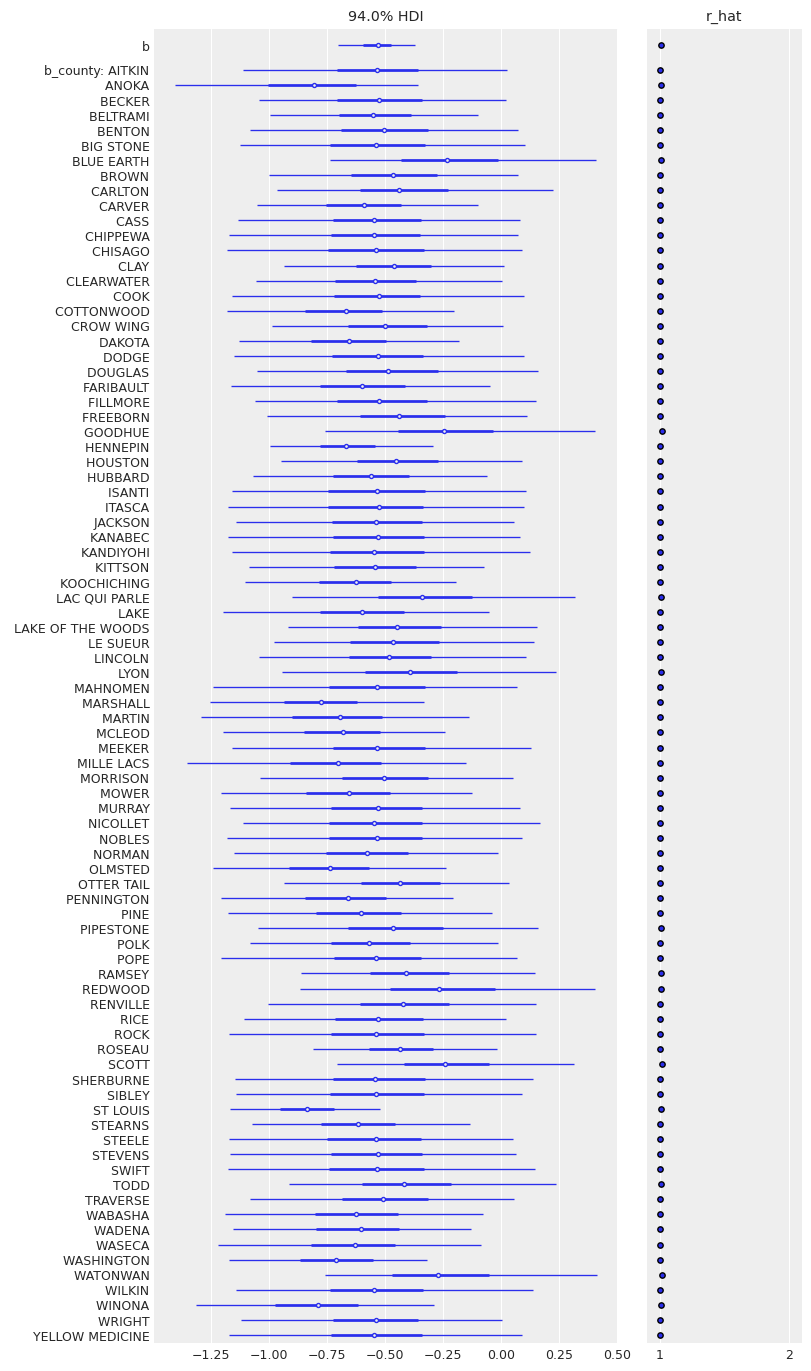

In [33]:
az.plot_forest(
    varying_slope_idata, var_names=["b", "b_county"], r_hat=True, combined=True, textsize=9
);

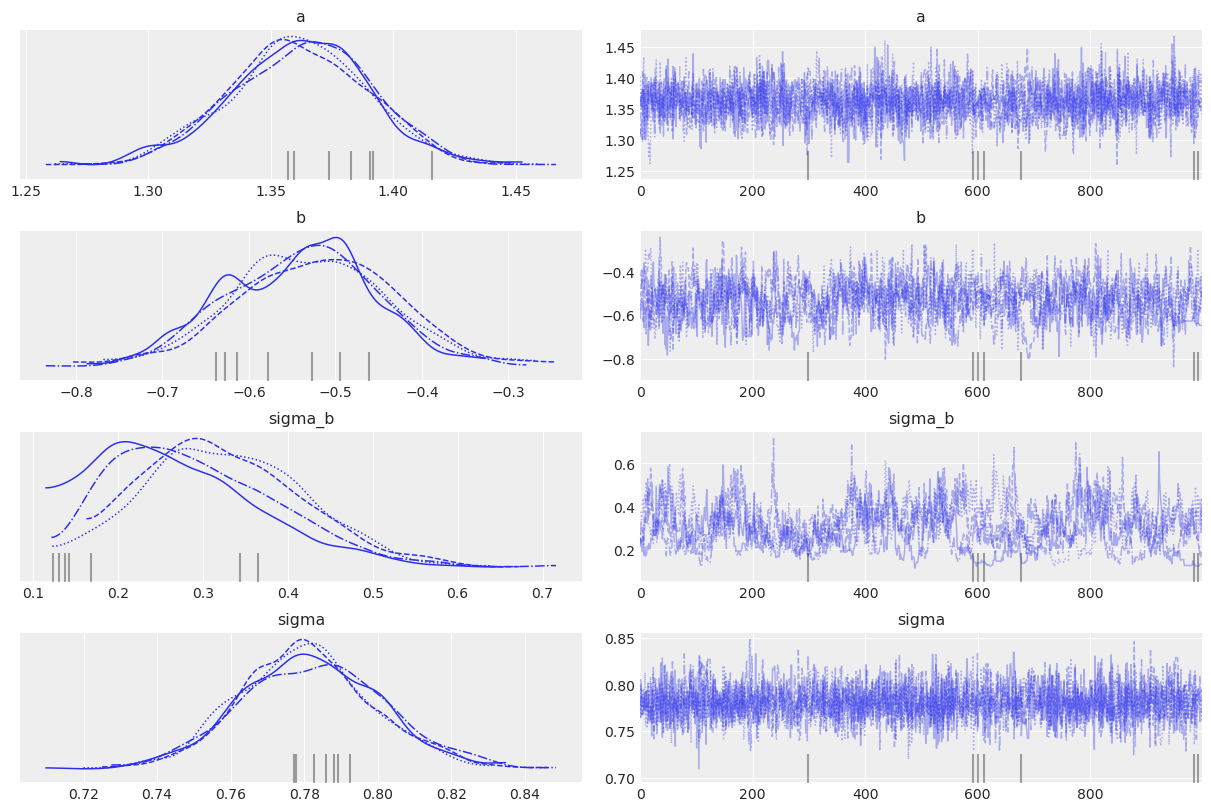

In [35]:
az.plot_trace(varying_slope_idata, var_names=["a", "b", "sigma_b", "sigma"]);

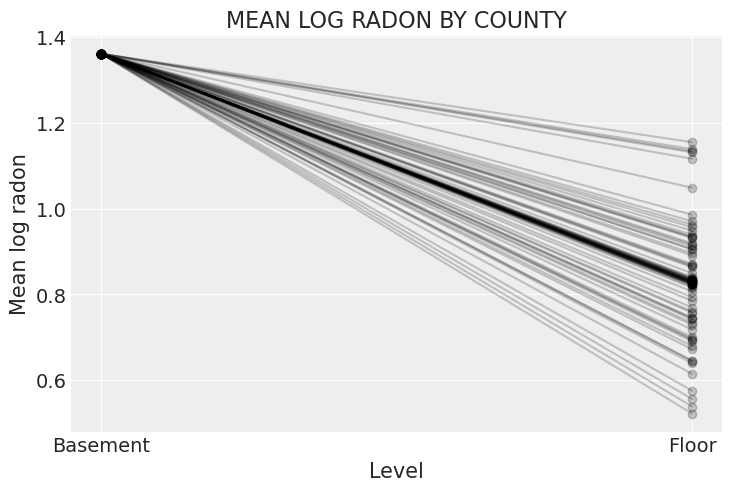

In [37]:
post = varying_slope_idata.posterior
theta = (
    (post.a + post.b_county * xvals).mean(dim=("chain", "draw")).to_dataset(name="Mean log radon")
)

_, ax = plt.subplots()
theta.plot.scatter(x="Level", y="Mean log radon", alpha=0.2, color="k", ax=ax)
ax.plot(xvals, theta["Mean log radon"].T, "k-", alpha=0.2)
ax.set_title("MEAN LOG RADON BY COUNTY");

## Exercise: Varying intercept and slope model

The most general model allows both the intercept and slope to vary by county:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_{i} + \epsilon_i$$

Combine the two previous models to create a version with both slopes and intercepts varying:

In [ ]:
with Model() as varying_intercept_slope:
    
    # Write your model here

In [ ]:
with varying_intercept_slope:
    varying_intercept_slope_idata = pm.sample(
        tune=2000, random_seed=RANDOM_SEED, return_inferencedata=True
    )

In [ ]:
az.plot_trace(varying_intercept_slope_idata, compact=True, chain_prop={"ls": "-"});

In [ ]:
post = varying_intercept_slope_idata.posterior
theta = (
    (post.? + post.? * xvals).mean(dim=("chain", "draw")).to_dataset(name="Mean log radon")
)

_, ax = plt.subplots()
theta.plot.scatter(x="Level", y="Mean log radon", alpha=0.2, color="k", ax=ax)
ax.plot(xvals, theta["Mean log radon"].T, "k-", alpha=0.2)
ax.set_title("MEAN LOG RADON BY COUNTY");

## Full varying model

## Adding group-level predictors

A primary strength of multilevel models is the ability to handle predictors on multiple levels simultaneously. If we consider the varying-intercepts model above:

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

we may, instead of a simple random effect to describe variation in the expected radon value, specify another regression model with a county-level covariate. Here, we use the county uranium reading $u_j$, which is thought to be related to radon levels:

$$\alpha_j = \gamma_0 + \gamma_1 u_j + \zeta_j$$

$$\zeta_j \sim N(0, \sigma_{\alpha}^2)$$

Thus, we are now incorporating a house-level predictor (floor or basement) as well as a county-level predictor (uranium).

Note that the model has both indicator variables for each county, plus a county-level covariate. In classical regression, this would result in collinearity. In a multilevel model, the partial pooling of the intercepts towards the expected value of the group-level linear model avoids this.

Group-level predictors also serve to reduce group-level variation $\sigma_{\alpha}$. An important implication of this is that the group-level estimate induces stronger pooling.

In [ ]:
from pymc3 import Deterministic

with Model() as hierarchical_intercept:
    
    # Priors
    σ_a = HalfCauchy('σ_a', 5)
    
    # County uranium model
    γ_0 = Normal('γ_0', mu=0., sigma=10)
    γ_1 = Normal('γ_1', mu=0., sigma=10)
    
    
    # Uranium model for intercept
    μ_a = γ_0 + γ_1*log_uranium
    # County variation not explained by uranium
    ϵ_a = Normal('ϵ_a', mu=0, sigma=1, shape=n_counties)
    a = Deterministic('a', μ_a + σ_a*ϵ_a[county])
    
    # Common slope
    b = Normal('b', mu=0., sigma=10)
    
    # Model error
    σ_y = Uniform('σ_y', lower=0, upper=100)
    
    # Expected value
    y_hat = a + b * floor_measure
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=σ_y, observed=log_radon)
    

In [ ]:
with hierarchical_intercept:
    hierarchical_intercept_trace = sample(1000, tune=1000, cores=2, random_seed=RANDOM_SEED)

In [ ]:
a_means = hierarchical_intercept_trace['a'].mean(axis=0)
plt.scatter(log_uranium, a_means)
g0 = hierarchical_intercept_trace['γ_0'].mean()
g1 = hierarchical_intercept_trace['γ_1'].mean()
xvals = np.linspace(-1, 0.8)
plt.plot(xvals, g0+g1*xvals, 'k--')
plt.xlim(-1, 0.8)

a_se = hierarchical_intercept_trace['a'].std(axis=0)
for ui, m, se in zip(log_uranium, a_means, a_se):
    plt.plot([ui,ui], [m-se, m+se], 'b-')
plt.xlabel('County-level uranium'); plt.ylabel('Intercept estimate');

The standard errors on the intercepts are narrower than for the partial-pooling model without a county-level covariate.

### Correlations among levels

In some instances, having predictors at multiple levels can reveal correlation between individual-level variables and group residuals. We can account for this by including the average of the individual predictors as a covariate in the model for the group intercept.

$$\alpha_j = \gamma_0 + \gamma_1 u_j + \gamma_2 \bar{x} + \zeta_j$$

These are broadly referred to as ***contextual effects***.

In [ ]:
# Create new variable for mean of floor across counties
xbar = radon_data.groupby('county')['floor'].mean().rename(county_lookup).values

In [ ]:
with Model() as contextual_effect:
    
    # Priors
    σ_a = HalfCauchy('σ_a', 5)
    
    # County uranium model for slope
    γ = Normal('γ', mu=0., sigma=10, shape=3)
    
    # Uranium model for intercept
    μ_a = Deterministic('μ_a', γ[0] + γ[1]*log_uranium + γ[2]*xbar[county])

    # County variation not explained by uranium
    ϵ_a = Normal('ϵ_a', mu=0, sigma=1, shape=n_counties)
    a = Deterministic('a', μ_a + σ_a*ϵ_a[county])

    # Common slope
    b = Normal('b', mu=0., sigma=10)
    
    # Model error
    σ_y = Uniform('σ_y', lower=0, upper=100)
    
    # Expected value
    y_hat = a + b * floor_measure
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=σ_y, observed=log_radon)
    

In [ ]:
with contextual_effect:
    contextual_effect_trace = sample(1000, tune=1000, cores=2, random_seed=RANDOM_SEED)

In [ ]:
plot_forest(contextual_effect_trace, var_names=['γ']);

In [ ]:
summary(contextual_effect_trace, var_names=['γ'])

So, we might infer from this that counties with higher proportions of houses without basements tend to have higher baseline levels of radon. Perhaps this is related to the soil type, which in turn might influence what type of structures are built.

### Prediction

Gelman (2006) used cross-validation tests to check the prediction error of the unpooled, pooled, and partially-pooled models

**root mean squared cross-validation prediction errors**:

* unpooled = 0.86
* pooled = 0.84
* multilevel = 0.79

There are two types of prediction that can be made in a multilevel model:

1. a new individual within an existing group
2. a new individual within a new group

For example, if we wanted to make a prediction for a new house with no basement in St. Louis county, we just need to sample from the radon model with the appropriate intercept.

In [ ]:
county_lookup['ST LOUIS']

That is, 

$$\tilde{y}_i \sim N(\alpha_{69} + \beta (x_i=1), \sigma_y^2)$$

This is a matter of adding a single additional line in PyMC:

In [ ]:
with Model() as contextual_pred:
    
    # Priors
    σ_a = HalfCauchy('σ_a', 5)
    
    # County uranium model for slope
    γ = Normal('γ', mu=0., sigma=10, shape=3)
    
    # Uranium model for intercept
    μ_a = Deterministic('μ_a', γ[0] + γ[1]*log_uranium + γ[2]*xbar[county])

    # County variation not explained by uranium
    ϵ_a = Normal('ϵ_a', mu=0, sigma=1, shape=n_counties)
    a = Deterministic('a', μ_a + σ_a*ϵ_a[county])

    # Common slope
    b = Normal('b', mu=0., sigma=10)
    
    # Model error
    σ_y = Uniform('σ_y', lower=0, upper=100)
    
    # Expected value
    y_hat = a + b * floor_measure
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=σ_y, observed=log_radon)
    
    # St Louis county prediction
    stl_pred = Normal('stl_pred', mu=a[69] + b, sigma=σ_y)
    

In [ ]:
with contextual_pred:
    contextual_pred_trace = sample(2000, tune=1000, cores=2, random_seed=RANDOM_SEED)

In [ ]:
plot_posterior(contextual_pred_trace, var_names=['stl_pred']);

## Exercise

How would we make a prediction from a new county (*e.g.* one not included in this dataset)?

In [ ]:
# Write your answer here

## Benefits of Multilevel Models

- Accounting for natural hierarchical structure of observational data
- Estimation of coefficients for (under-represented) groups
- Incorporating individual- and group-level information when estimating group-level coefficients
- Allowing for variation among individual-level coefficients across groups


---
## References

Gelman, A., & Hill, J. (2006). Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.). Cambridge University Press.

Betancourt, M. J., & Girolami, M. (2013). Hamiltonian Monte Carlo for Hierarchical Models.

Gelman, A. (2006). Multilevel (Hierarchical) modeling: what it can and cannot do. Technometrics, 48(3), 432–435.